<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
import re
import time
import random
import numpy as np
import scipy as sp
import pickle
import hashlib

import PIL
import cv2 as cv

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from IPython.display import Image, display

%matplotlib inline

In [2]:
#%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.4.1
Eager mode: True
Found GPU at: /device:GPU:0


In [3]:
def show_image(image, title=None):
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(image.reshape(28, 28), cmap='Greys')
  if title is not None:
    plt.title(title)
  plt.show()

In [4]:
def show_prediction(image, truth, prediction, label_descriptions=None):
  prediction = np.argmax(prediction)
  prediction = prediction if label_descriptions is None else label_descriptions[prediction]
  truth = truth if label_descriptions is None else label_descriptions[truth]
  title = f"Prediction: {prediction} / Truth: {truth}"
  show_image(image, title)

In [5]:
def resize_image(image, size):
  height_zoom = size[1] / image.shape[0]
  width_zoom = size[0] / image.shape[1]
  image = sp.ndimage.zoom(image, (height_zoom, width_zoom), order=2)

  return image

In [6]:
def get_heatmap(cam, size, resize=True):
  heatmap = cam / np.max(cam)
 
  if resize:
    heatmap = resize_image(heatmap, size)
 
  return heatmap

In [7]:
def show_heatmap(img, cam, size, resize=True, title=None, detached=False, ax=None):
  img = img.reshape(size[0], size[1])
  heatmap = get_heatmap(cam, size, resize)

  # plot
  if ax is None:
    ax = plt.gca()

  ax.set_xticklabels([])
  ax.set_yticklabels([])

  if not detached:
    plt.figure(facecolor='white')
    plt.imshow(img, alpha=0.5, cmap='Greys')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')

    if title is not None:
      plt.title(title)
    
    plt.show()
  
  else:
    if title is not None:
      ax.set_title(title, fontdict=None, loc='center', color = "k")

    ax.imshow(img, alpha=0.5, cmap='Greys')
    ax.imshow(heatmap, cmap='jet', alpha=0.5)  

In [8]:
def plot_model_score(score, history):
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [9]:
def load_model(name):
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [10]:
def save_model(model, history, name):
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [11]:
def get_cam_layers(model):
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4 and last_conv_layer is None:
        last_conv_layer = layer
        # print("Last Conv Layer: %s, filters %s" % (layer.name, layer.filters))

      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [12]:
def get_layer(model, layer_name):
  for layer in model.layers:
    if layer.name == layer_name:
      return layer

  return None

In [13]:
def get_sample(test_set, idx=-1):
  test_idx = random.randint(0, len(test_set[0])) if idx < 0 else idx
  test_image = test_set[0][test_idx]
  test_label = np.argmax(test_set[1][test_idx])

  return test_image, test_label, test_idx

In [14]:
def predict(model, image):
  return model.predict(np.expand_dims(image, 0))

In [15]:
def get_prediction(model, test_set, idx=-1):
  x, y, idx = get_sample(test_set, idx)
  prediction = predict(model, x)

  return x, y, prediction, idx

In [16]:
def format_dataset(num_classes, train, test):
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

In [17]:
def copy_model(original_model, trainable=False):
  new_model = keras.models.clone_model(original_model)
  new_model.set_weights(original_model.get_weights())
  new_model.trainable = trainable
  return new_model

In [18]:
def get_grid_position(position, size):
  horizontal_labels = ['left', 'mid', 'right']
  vertical_labels = ['top', 'mid', 'bottom']
  
  horizontal_idx =  np.int0(np.minimum(position[0] / (size[0] / len(horizontal_labels)), len(horizontal_labels)-1))
  vertical_idx =  np.int0(np.minimum(position[1] / (size[1] / len(vertical_labels)), len(vertical_labels)-1))

  return vertical_labels[vertical_idx], horizontal_labels[horizontal_idx]

#MNIST

In [19]:
mnist_num_classes = 10
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(mnist_num_classes, mnist_train, mnist_test)

def create_mnist_model(name, input_shape, num_classes, train=None):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="mnist_first_conv"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.5),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", name="mnist_last_conv"),
          
          # layers.GlobalAveragePooling2D(),
          layers.Flatten(),
          layers.Dense(num_classes, activation="softmax", name="mnist_output"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

11493376/11490434 [==============================] - 0s 0us/step
(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


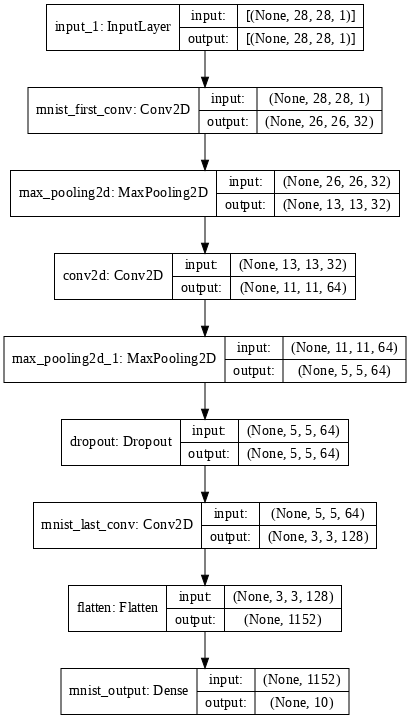

Epoch 1/15
422/422 [==============================] - 35s 7ms/step - loss: 0.6714 - accuracy: 0.8006 - val_loss: 0.0657 - val_accuracy: 0.9807
Epoch 2/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1003 - accuracy: 0.9693 - val_loss: 0.0566 - val_accuracy: 0.9828
Epoch 3/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0678 - accuracy: 0.9779 - val_loss: 0.0404 - val_accuracy: 0.9880
Epoch 4/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0512 - accuracy: 0.9843 - val_loss: 0.0323 - val_accuracy: 0.9908
Epoch 5/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0434 - accuracy: 0.9855 - val_loss: 0.0351 - val_accuracy: 0.9895
Epoch 6/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0348 - accuracy: 0.9894 - val_loss: 0.0344 - val_accuracy: 0.9897
Epoch 7/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0355 - accuracy: 0.9894 - val_loss: 0.0320 - val_accuracy: 0.9912
Epoch

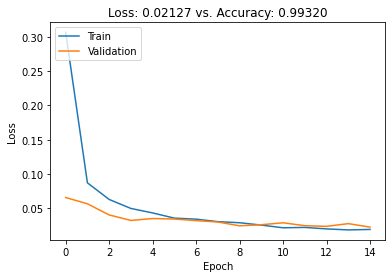

In [20]:
model_mnist = create_mnist_model("gap_shallow", (28, 28, 1), mnist_num_classes, mnist_train)
# model_mnist, history_mnist = load_model("gap_shallow")

display(keras.utils.plot_model(model_mnist, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.1)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))
# save_model(model_mnist, history_mnist, "gap_shallow")

# evaluate
score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_mnist, history_mnist.history)

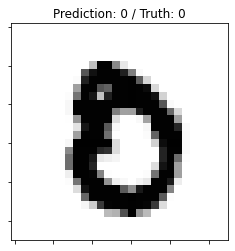

In [21]:
image, label, prediction, _ = get_prediction(model_mnist, mnist_test)
show_prediction(image, label, prediction)

#GEO

In [22]:
geo_dataset_proto = ("proto", "https://geo-cam.s3-eu-west-1.amazonaws.com/geocam.npz", ["vertical", "diagonal", "ellipse"])
geo_dataset_simple = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_round = ("round", "https://geo-cam.s3-eu-west-1.amazonaws.com/rounddataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_threesixty = ("threesixty", "https://geo-cam.s3-eu-west-1.amazonaws.com/threesixtydataset_dataset.npz", ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "110", "120", "130", "140", "150", "160", "170", "180"])

def get_geo_dataset(name, filepath):
  path = tf.keras.utils.get_file(name, filepath)
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [107]:
def create_geo_model(name, input_shape, num_classes):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="geo_first_conv"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.4),
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="geo_last_conv"),
          # layers.GlobalAveragePooling2D(),
          layers.Flatten(),
          layers.Dense(num_classes, activation="softmax", name="geo_output"),
      ]
  )

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

  return model

(28, 28)
1
x_train shape: (4200, 28, 28, 1)
4200 train samples
1800 test samples


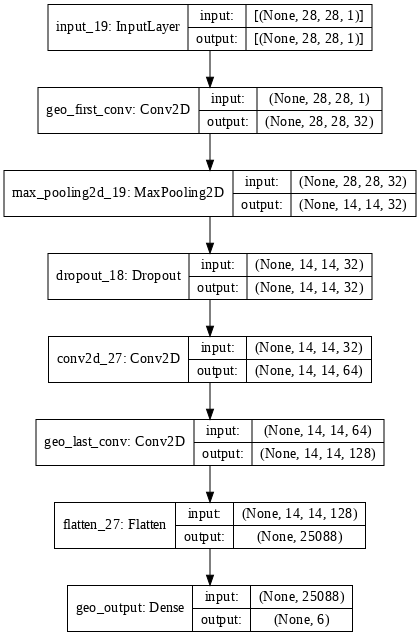

Epoch 1/15
25/25 [==============================] - 1s 19ms/step - loss: 1.5668 - accuracy: 0.3458 - val_loss: 1.1246 - val_accuracy: 0.5857
Epoch 2/15
25/25 [==============================] - 0s 12ms/step - loss: 0.9074 - accuracy: 0.6729 - val_loss: 0.3979 - val_accuracy: 0.8695
Epoch 3/15
25/25 [==============================] - 0s 11ms/step - loss: 0.3518 - accuracy: 0.8791 - val_loss: 0.2310 - val_accuracy: 0.9200
Epoch 4/15
25/25 [==============================] - 0s 11ms/step - loss: 0.1987 - accuracy: 0.9311 - val_loss: 0.1836 - val_accuracy: 0.9295
Epoch 5/15
25/25 [==============================] - 0s 10ms/step - loss: 0.1475 - accuracy: 0.9410 - val_loss: 0.1514 - val_accuracy: 0.9381
Epoch 6/15
25/25 [==============================] - 0s 10ms/step - loss: 0.1317 - accuracy: 0.9494 - val_loss: 0.1305 - val_accuracy: 0.9495
Epoch 7/15
25/25 [==============================] - 0s 11ms/step - loss: 0.0961 - accuracy: 0.9630 - val_loss: 0.1179 - val_accuracy: 0.9562
Epoch 8/15
25

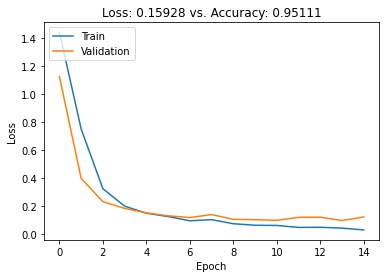

In [108]:
# dataset
dataset = geo_dataset_simple
geo_train, geo_test = get_geo_dataset(dataset[0], dataset[1])
geo_train, geo_test = format_dataset(len(dataset[2]), geo_train, geo_test)

# model
model_geo = create_geo_model("geocam", (28, 28, 1), len(dataset[2]))
# model_geo, history_geo = load_model("geo")

display(keras.utils.plot_model(model_geo, show_shapes=True, dpi=72))

start_time = time.perf_counter()
history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=15, validation_split=0.25)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))
# save_model(model_geo, history_geo, "geo")

score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)
plot_model_score(score_geo, history_geo.history)

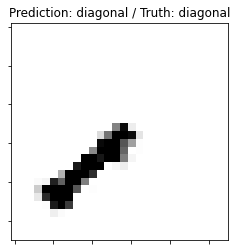

In [43]:
image, truth, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, truth, prediction, dataset[2])

# Transfer-learning


Model: "model_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
geo_first_conv (Conv2D)         (None, 28, 28, 32)   320         input_19[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 14, 14, 32)   0           geo_first_conv[1][0]             
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 14, 14, 32)   0           max_pooling2d_19[1][0]           
___________________________________________________________________________________________

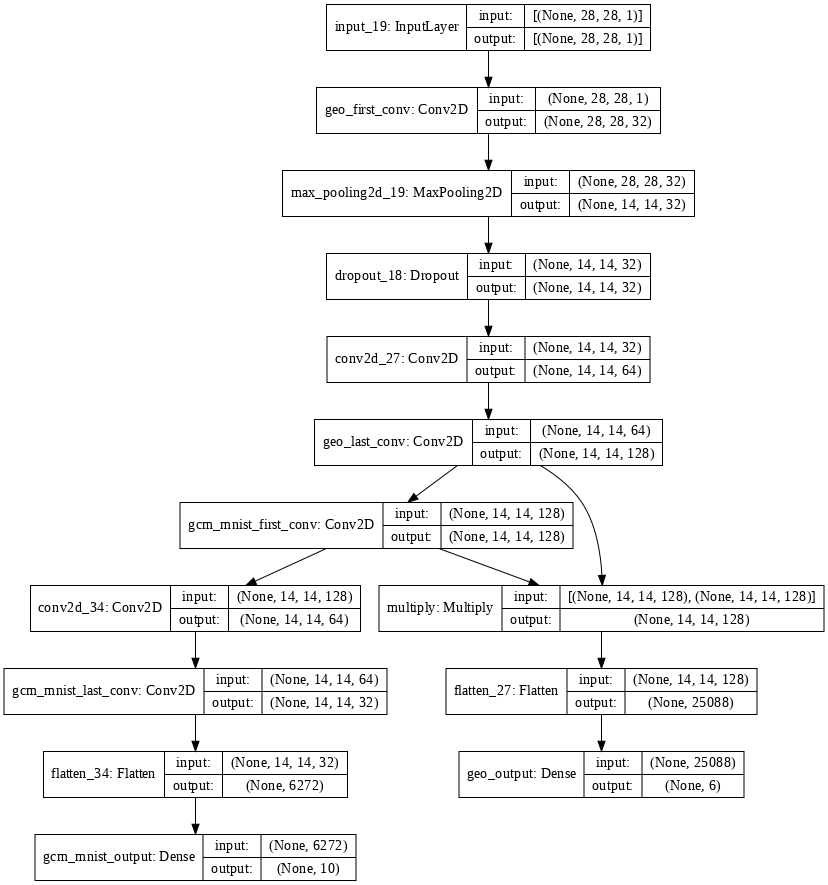

Epoch 1/5
375/375 [==============================] - 5s 11ms/step - loss: 0.3850 - accuracy: 0.8815 - val_loss: 0.0789 - val_accuracy: 0.9765
Epoch 2/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0841 - accuracy: 0.9731 - val_loss: 0.0690 - val_accuracy: 0.9804
Epoch 3/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0621 - accuracy: 0.9816 - val_loss: 0.0614 - val_accuracy: 0.9826
Epoch 4/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0574 - accuracy: 0.9817 - val_loss: 0.0762 - val_accuracy: 0.9772
Epoch 5/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0580 - accuracy: 0.9817 - val_loss: 0.0638 - val_accuracy: 0.9808
Training took: 20.90 seconds


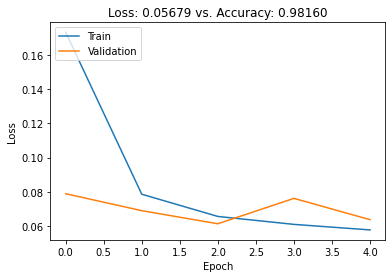

In [148]:
geo_model_copy = copy_model(model_geo, False)
input = geo_model_copy.input
geo_last, geo2_last, last = input, None, None

# utilize a lambda layer to convert the 3 channel input to a grayscale representation
# geo_last = layers.Lambda(lambda c: tf.image.rgb_to_grayscale(c))(input)
  
for layer in get_cam_layers(geo_model_copy)[0]:
  layer.trainable = False
  geo_last = layer(geo_last)

last = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="gcm_mnist_first_conv")(geo_last)

# piggi_back = layers.Attention(causal=True, dropout=0)([geo_last, last])
piggi_back = layers.Multiply()([geo_last, last])
piggi_back.trainable = False

for layer in get_cam_layers(geo_model_copy)[1]:
  layer.trainable = False
  geo2_last = layer(piggi_back) if geo2_last is None else layer(geo2_last)

last = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(last)
last = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="gcm_mnist_last_conv")(last)

last = layers.Flatten()(last)
last = layers.Dense(mnist_num_classes, activation="softmax", name="gcm_mnist_output")(last)

model_gcm = Model(inputs=input, outputs=last)
model_gcm_complete = Model(inputs=input, outputs=[last, geo2_last])

opt = keras.optimizers.Adam(learning_rate=0.004)
model_gcm.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model_gcm_complete.summary()
display(keras.utils.plot_model(model_gcm_complete, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_geocam = model_gcm.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=5, validation_split=0.2)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))

# evaluate
score_gcm = model_gcm.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_gcm, history_geocam.history)

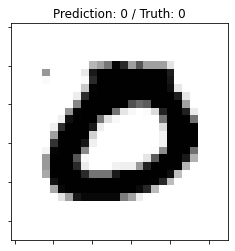

In [48]:
image, label, prediction, _ = get_prediction(model_gcm, mnist_test)
show_prediction(image, label, prediction)

# CAMs

In [28]:
def cam(model, conv_outputs, prediction_idx):
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[0][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  return cam

In [29]:
def grad_cam_m(image, cam_model, prediction_idx=-1, prediction_output=-1):
  with tf.GradientTape() as tape:
    conv_output, predictions = cam_model(np.expand_dims(image, 0))
    if len(predictions) > 1:
      predictions = predictions[prediction_output] if prediction_output >= 0 else predictions[0]
    prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
    output = predictions[:, prediction_idx]

  grads = tape.gradient(output, conv_output)
  # print(f"{prediction_idx} -> {hashlib.sha256(grads).hexdigest().upper()}")
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  conv_output = conv_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()

  for i in range(pooled_grads.shape[-1]):
    conv_output[:, :, i] *= pooled_grads[i]

  cam = np.mean(conv_output, axis=-1)

  return cam, conv_output, predictions, pooled_grads

def grad_cam(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_m(image, cam_model, prediction_idx)

In [30]:
def grad_cam_pp_m(image, cam_model, prediction_idx=-1, prediction_output=-1):
  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
              conv_output, predictions = cam_model(np.expand_dims(image, 0))
              if len(predictions) > 1:
                predictions = predictions[prediction_output] if prediction_output >= 0 else predictions[0]
              prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
              output = predictions[:, prediction_idx]
              conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

  return cam, conv_output, predictions, (conv_first_grad, conv_second_grad, conv_third_grad)

def grad_cam_pp(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_pp_m(image, cam_model, prediction_idx)

# Experiments

In [31]:
# Agregate the descriptions of 500 numbers 5 and see if the descriptions 
# match -> most likely explanation -> general descriptions of a number 5 and general description (ambiguity in the knowledge datatset)

# 1 - go back to same architecture G1 -> M1 -> M2 
# 2 - cam from the first layer of M1 -> mask 
# 3 - check all cam action maps from last layer of G1 -> G2
# 4 - check 

In [149]:
# geo2 (sliced) model (from model_gcm - transfer learning) for cam prediction
model_geocam = Model([model_geo.inputs], [get_layer(model_geo, "geo_last_conv").get_output_at(0), model_geo.output])

model_gcmcam_1 = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "gcm_mnist_first_conv").get_output_at(0), 
                      model_gcm_complete.output])

model_gcmcam = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "geo_last_conv").get_output_at(1), 
                      model_gcm_complete.output])

In [151]:
def get_cam_predictions(test_image, model, classes, cam_method=grad_cam_m, threshold=180):
  cam_predictions = dict()
  cam_activations = dict()
  cam_thresholds = dict()
  min_cam_activation, max_cam_activation = 0, 0

  for category in range(classes):
    cam, _, _, _ = cam_method(test_image, model, category, 1)
    cam_activations[category] = cam
    min, max = np.min(cam), np.max(cam)
    min_cam_activation = np.minimum(min, min_cam_activation)
    max_cam_activation = np.maximum(max, max_cam_activation)

  for category in range(classes):
    cam = cam_activations[category]
    perc = (cam - min_cam_activation) / (max_cam_activation - min_cam_activation)
    
    cam = resize_image(perc, (28, 28)) * 255
    _, cam = cv.threshold(cam, threshold, 255, cv.THRESH_BINARY)
    cam_thresholds[category] = cam
    cv_img = np.array(cam, dtype = np.uint8)
    contours, _ = cv.findContours(cv_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    cam_predictions[category] = (np.max(perc), [])

    for i in range(len(contours)):
      moments = cv.moments(contours[i])
      if moments['m00'] > 0:
        center = (int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00']))
        cam_predictions[category][1].append(center)
  
  return cam_activations, cam_thresholds, cam_predictions

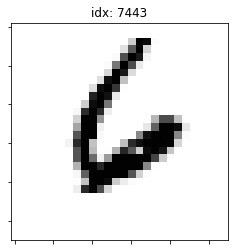

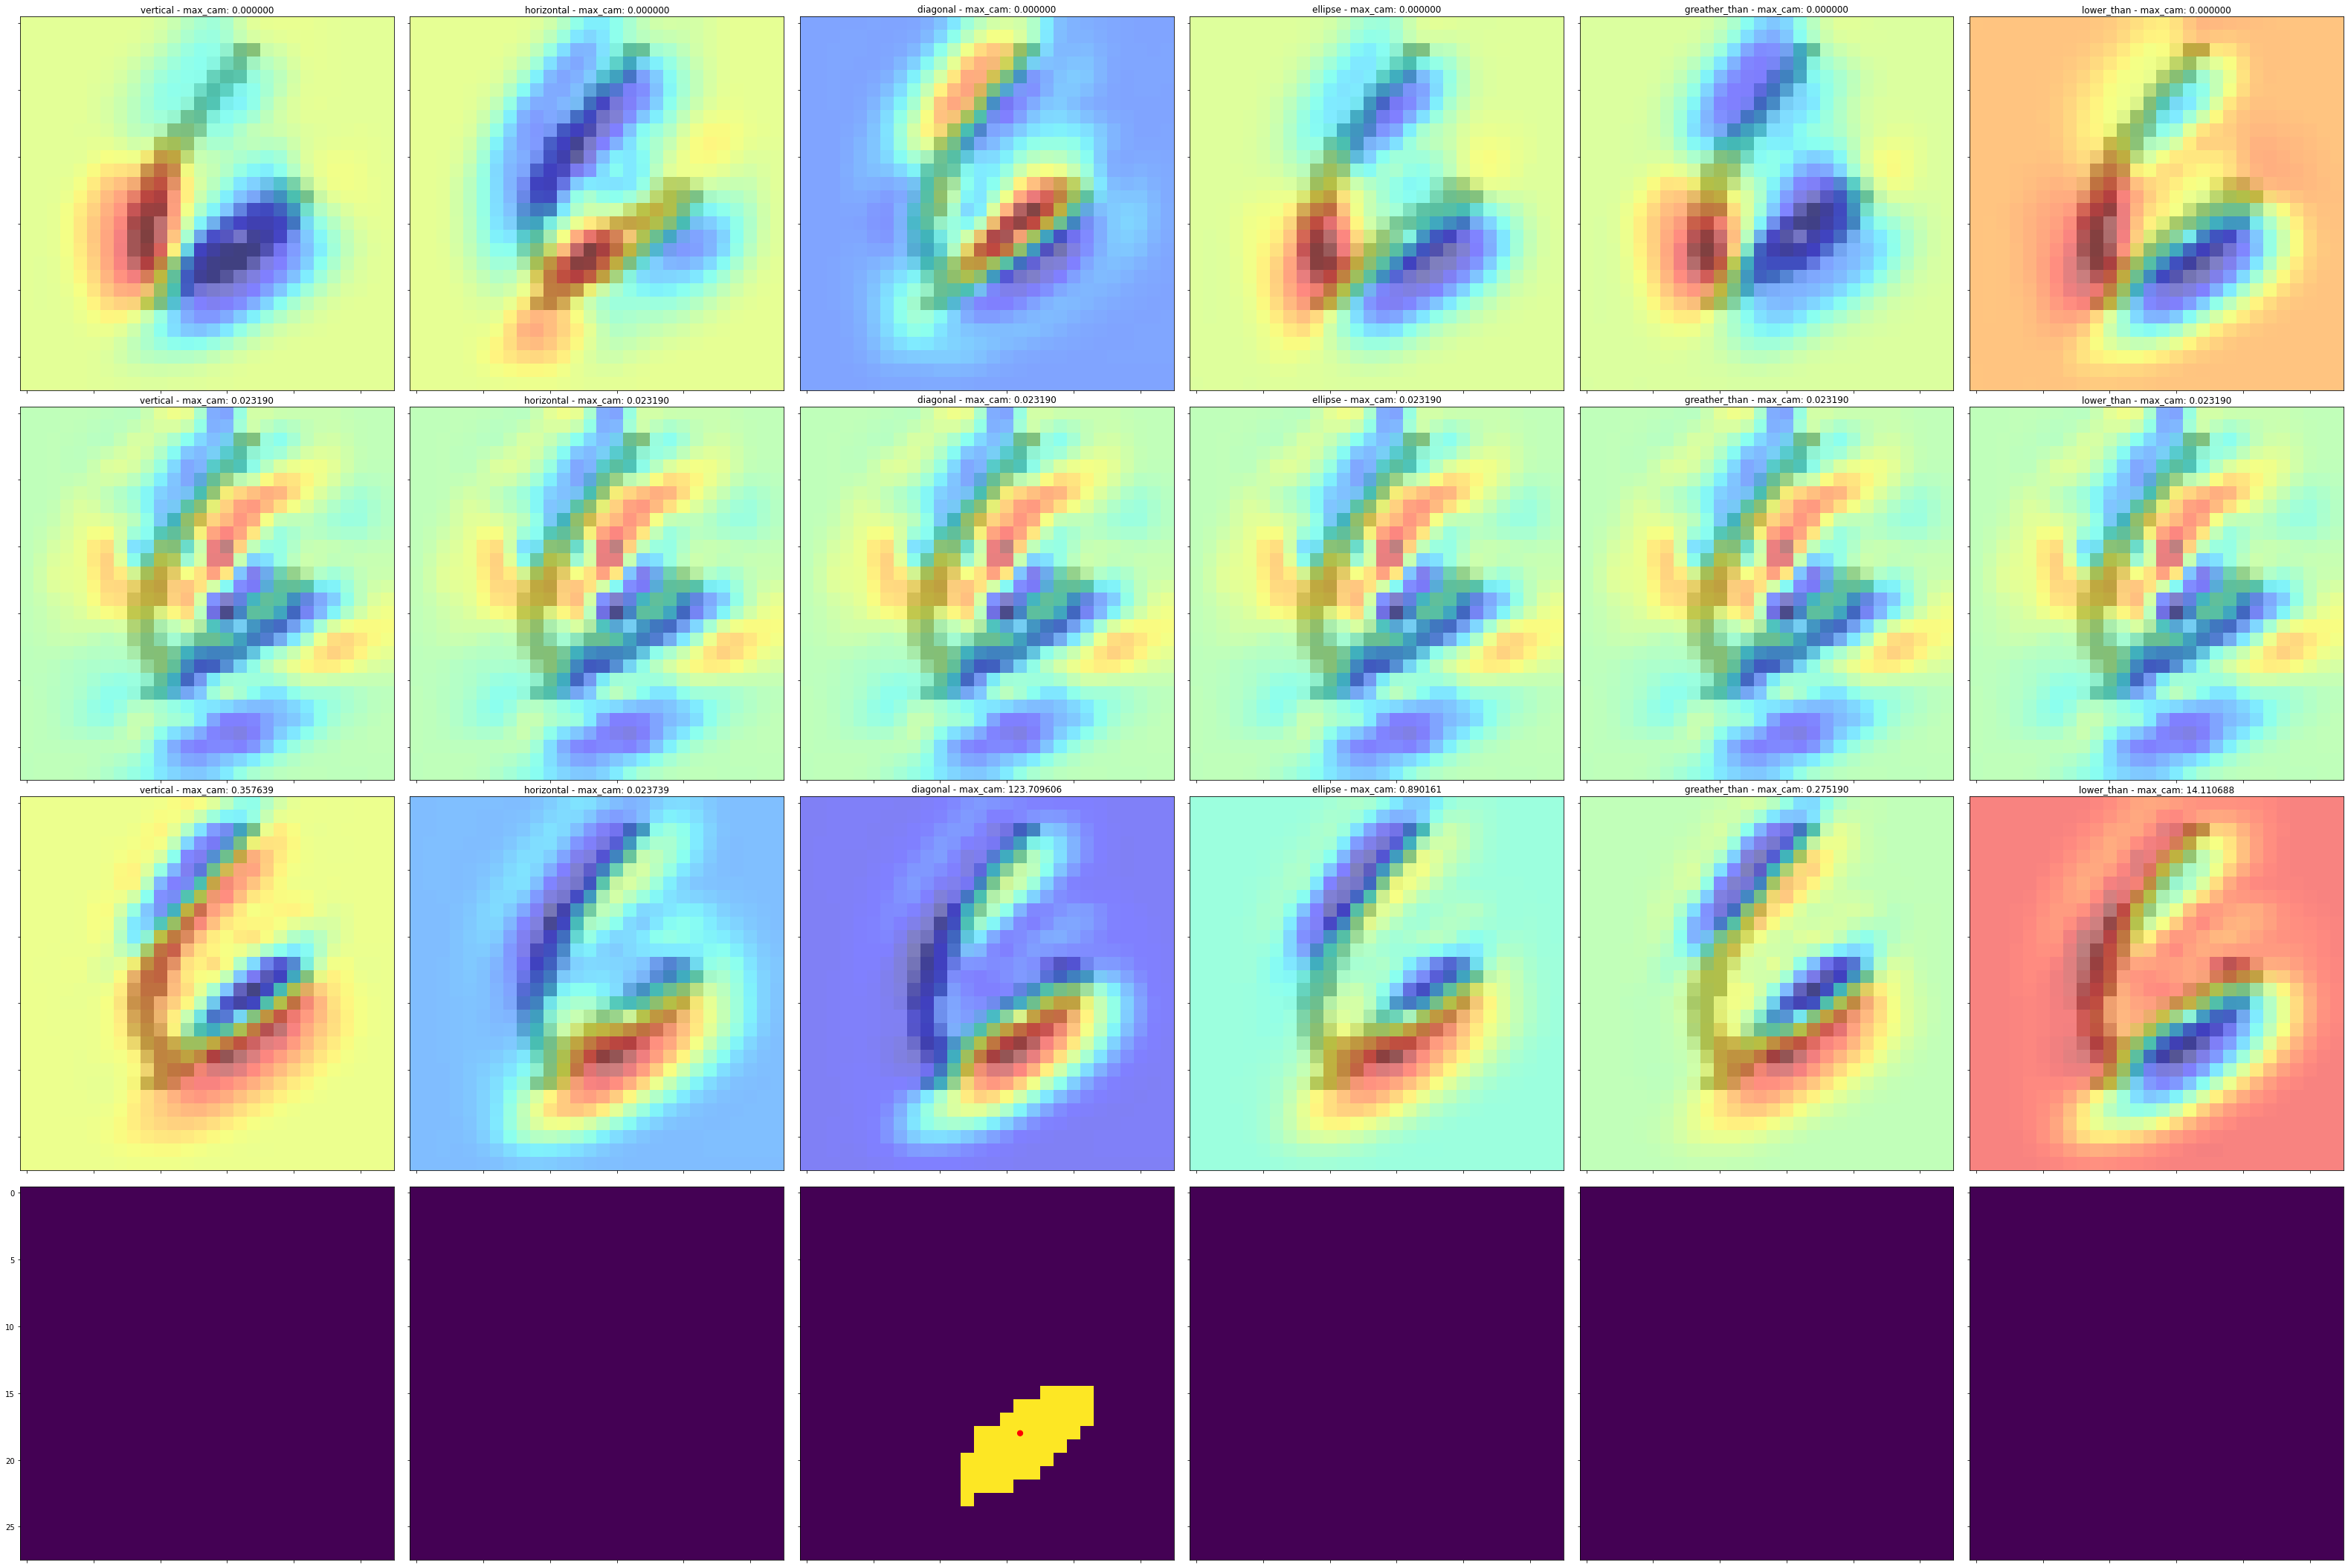

In [152]:
from mpl_toolkits.axes_grid1 import ImageGrid

# prediction based on conv output (5056, 6146, 2365, 2587, 5310)
test_image, test_label, test_idx = get_sample(mnist_test)
mnist_gcm_predictions = predict(model_gcm, test_image)
mnist_gcm_prediction = np.argmax(mnist_gcm_predictions)

show_image(test_image, f"idx: {test_idx}")
assert test_label == mnist_gcm_prediction, "Missmatched ids. Wanted %d, received %d" % (test_label, mnist_gcm_prediction)

geo_labels = dataset[2]

# start plotting
fig = plt.figure(figsize=(56, 56))
grid = ImageGrid(fig, 111, nrows_ncols=(4, len(geo_labels)), axes_pad=0.3, label_mode="1")

# pure geo
image_idx = 0
for category in range(len(geo_labels)):
  cam, _, _, _ = grad_cam_m(test_image, model_geocam, category)
  title = f"{geo_labels[category]} - max_cam: {np.max(cam) * 100000000:.6f}"
  show_heatmap(test_image, cam, (28, 28, 1), True, title, detached=True, ax=grid[image_idx])
  image_idx += 1

# gcm minist first
for category in range(len(geo_labels)):
  cam, _, _, _ = grad_cam_m(test_image, model_gcmcam_1)#, category, 1)
  title = f"{geo_labels[category]} - max_cam: {np.max(cam) * 100000000:.6f}"
  show_heatmap(test_image, cam, (28, 28, 1), True, title, detached=True, ax=grid[image_idx])
  image_idx += 1

# geocam
cam_activations, cam_thresholded, cam_predictions = get_cam_predictions(test_image, model_gcmcam, len(geo_labels), cam_method=grad_cam_m, threshold=200)

for i in range(len(cam_activations)):
  cam = cam_activations[i]
  title = f"{geo_labels[i]} - max_cam: {np.max(cam) * 100000000:.6f}"
  show_heatmap(test_image, cam, (28, 28, 1), True, title, detached=True, ax=grid[image_idx])
  image_idx += 1

for i in range(len(cam_thresholded)):
  camt = cam_thresholded[i]
  camp = cam_predictions[i]

  grid[image_idx].imshow(camt)

  for j in range(len(camp[1])):
    camp_center = camp[1][j]
    grid[image_idx].add_patch(plt.Circle(camp_center, 0.2, color='r'))

  image_idx += 1

plt.show()

In [153]:
samples = 10
descriptions = dict()
with tqdm(total=(samples * mnist_num_classes), position=0, leave=True) as pbar:
  for category in range(mnist_num_classes):
      descriptions[category] = dict()
      for geo_class in range(len(dataset[2])):
          descriptions[category][dataset[2][geo_class]] = dict()

      for i in range(samples):
        validation_idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))[0]
        test_mnist_image = mnist_test[0][validation_idx]

        # geo cam
        _, _, cam_predictions = get_cam_predictions(test_mnist_image, model_gcmcam, len(dataset[2]), cam_method=grad_cam_m, threshold=200)
        
        for key in cam_predictions:
          verbose_key = dataset[2][key]
          max = 0
          for pos in cam_predictions[key][1]:
            verbose_position = get_grid_position(pos, (28,28))
            val = descriptions[category][verbose_key].get(verbose_position)
            if not val:
              descriptions[category][verbose_key][verbose_position] = 1
            else:
              descriptions[category][verbose_key][verbose_position] = val + 1
            max = np.maximum(max, descriptions[category][verbose_key][verbose_position])

        pbar.update()

# out
print("\n\nDESCRIPTION:")

for category in range(mnist_num_classes):
  print(f"- {category}:")
  for description_key in descriptions[category]:
    positions = descriptions[category][description_key]
    amount  = 0
    for k in positions:
      amount = amount + positions[k]
    
    print(f"\t- {description_key} - {amount} : {positions}")


100%|██████████| 100/100 [00:05<00:00, 18.36it/s]



DESCRIPTION:
- 0:
	- vertical - 3 : {('mid', 'mid'): 1, ('bottom', 'mid'): 2}
	- horizontal - 7 : {('mid', 'mid'): 3, ('top', 'mid'): 4}
	- diagonal - 1 : {('top', 'mid'): 1}
	- ellipse - 4 : {('mid', 'mid'): 2, ('top', 'mid'): 2}
	- greather_than - 5 : {('top', 'mid'): 3, ('bottom', 'mid'): 1, ('mid', 'mid'): 1}
	- lower_than - 3 : {('top', 'mid'): 3}
- 1:
	- vertical - 1 : {('bottom', 'mid'): 1}
	- horizontal - 9 : {('top', 'mid'): 6, ('mid', 'mid'): 3}
	- diagonal - 1 : {('top', 'mid'): 1}
	- ellipse - 4 : {('top', 'mid'): 1, ('mid', 'left'): 2, ('top', 'left'): 1}
	- greather_than - 8 : {('mid', 'mid'): 4, ('bottom', 'mid'): 2, ('mid', 'right'): 1, ('top', 'mid'): 1}
	- lower_than - 4 : {('top', 'mid'): 2, ('top', 'left'): 1, ('mid', 'mid'): 1}
- 2:
	- vertical - 1 : {('mid', 'mid'): 1}
	- horizontal - 10 : {('mid', 'mid'): 2, ('top', 'mid'): 7, ('top', 'left'): 1}
	- diagonal - 0 : {}
	- ellipse - 1 : {('mid', 'mid'): 1}
	- greather_than - 3 : {('top', 'mid'): 1, ('bottom', 'mid

# Metrics

In [154]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm 

digit_decomposition_categories = ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"]
digits_descriptions = [
  ["ellipse"], #0
  ["vertical", "diagonal"], #1
  ["horizontal", "diagonal", "ellipse"], #2
  ["greather_than", "lower_than", "ellipse"], #3
  ["vertical", "horizontal"], #4
  ["greather_than", "ellipse", "vertical", "horizontal"], #5
  ["diagonal", "vertical", "ellipse"], #6
  ["diagonal", "vertical", "horizontal"], #7
  ["ellipse"], #8
  ["ellipse", "diagonal", "vertical"], #9
]

samples = 50
metrics, y_true, y_pred = dict(), dict(), dict()

with tqdm(total=(samples * mnist_num_classes), position=0, leave=True) as pbar:
  for category in range(mnist_num_classes):
    metrics[category] = dict()
    
    decomposed_category = np.zeros(shape=(mnist_num_classes))
    decomposed_category[category] = 1
    
    y_true[category] = np.zeros(shape=(samples))
    y_pred[category] = np.zeros(shape=(samples))

    for i in range(samples):
      validation_idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))[0]
      test_mnist_image = mnist_test[0][validation_idx]

      # geo cam
      _, _, cam_predictions = get_cam_predictions(test_mnist_image, model_gcmcam, len(dataset[2]), cam_method=grad_cam_m, threshold=200)

      # prediction
      y_pred[category][i] = 0
      
      for geo_label in digits_descriptions[category]:
        geo_label_idx = dataset[2].index(geo_label)
        geo_prob = cam_predictions[geo_label_idx][0]
        if len(cam_predictions[geo_label_idx][1]) > 0 and geo_prob > y_pred[category][i]:
          y_pred[category][i] = 1
      
      pbar.update()

    # metrics per category
    metrics[category]['accuracy']   = accuracy_score(y_true[category], y_pred[category])
    metrics[category]['precision']  = precision_score(y_true[category], y_pred[category], average='weighted', zero_division=0)
    metrics[category]['recall']     = recall_score(y_true[category], y_pred[category], average='weighted', zero_division=0)
    metrics[category]['f1']         = f1_score(y_true[category], y_pred[category], average='weighted', zero_division=0)

# out
print("\n\nMETRICS:")

# macro metrics
print("\nMacro:")
macro_metrics = dict()
for cat in metrics:
  for key in metrics[cat]:
    macro_metrics[key] = macro_metrics.get(key) or []
    macro_metrics[key].append(metrics[cat][key])
  
for key in macro_metrics:
  print(f"- {key}: {np.average(macro_metrics[key]):.2f}")

# micro metrics
print("\nMicro:")
for cat in metrics:
  all_metrics = ', '.join([f"{key}:{np.average(metrics[cat][key]):.2f}" for key in metrics[cat]])
  print(f"- {cat}: {all_metrics}")

100%|██████████| 500/500 [00:27<00:00, 18.49it/s]



METRICS:

Macro:
- accuracy: 0.42
- precision: 0.90
- recall: 0.42
- f1: 0.52

Micro:
- 0: accuracy:0.68, precision:1.00, recall:0.68, f1:0.81
- 1: accuracy:0.64, precision:1.00, recall:0.64, f1:0.78
- 2: accuracy:0.04, precision:1.00, recall:0.04, f1:0.08
- 3: accuracy:0.28, precision:1.00, recall:0.28, f1:0.44
- 4: accuracy:0.62, precision:1.00, recall:0.62, f1:0.77
- 5: accuracy:0.00, precision:0.00, recall:0.00, f1:0.00
- 6: accuracy:0.42, precision:1.00, recall:0.42, f1:0.59
- 7: accuracy:0.04, precision:1.00, recall:0.04, f1:0.08
- 8: accuracy:0.68, precision:1.00, recall:0.68, f1:0.81
- 9: accuracy:0.76, precision:1.00, recall:0.76, f1:0.86


# Archive

In [ ]:
raise Exception('do not run any further')

In [ ]:
# Predictions
_, predictions = model_gcmcam(np.expand_dims(test_image, 0))
sorted_indexes = np.flip(np.argsort(predictions[1][0]))
percentages = np.round(predictions[1][0] / predictions[1][0][sorted_indexes[0]], 5)

print(f"1st : {dataset[2][sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {dataset[2][sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {dataset[2][sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

In [132]:
# verifying transfer learning
print(f"geo conv weights: {hashlib.sha256(get_layer(model_geo, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")
print(f"gcm1 conv weights: {hashlib.sha256(get_layer(model_gcm, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")
print(f"gcm2 conv weights: {hashlib.sha256(get_layer(model_gcm_complete, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")

print(f"geo conv biases: {hashlib.sha256(get_layer(model_geo, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")
print(f"gcm1 conv biases: {hashlib.sha256(get_layer(model_gcm, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")
print(f"gcm2 conv biases: {hashlib.sha256(get_layer(model_gcm_complete, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")

test_image, test_label, test_idx = get_sample(mnist_test)
test_geo = Model([model_geo.inputs], [get_layer(model_geo, 'geo_last_conv').get_output_at(0), model_geo.output])
test_gcm = Model([model_gcm_complete.inputs], [get_layer(model_gcm_complete, 'geo_last_conv').get_output_at(1), 
                                               get_layer(model_gcm_complete, "geo_output").get_output_at(0)])
test_gcm_ = Model([model_gcm_complete.inputs], [get_layer(model_gcm_complete, 'gcm_mnist_first_conv').get_output_at(0), 
                                               get_layer(model_gcm_complete, "geo_output").get_output_at(0)])

print(f"geo conv activations: {hashlib.sha256(test_geo(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")
print(f"gcm conv activations: {hashlib.sha256(test_gcm(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")
print(f"gcm alterate conv activations: {hashlib.sha256(test_gcm_(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")

geo conv weights: EDF6B8A8B5C9DF5AF7273CC461C224BEF29A5B79361C717450790F4773FA4451
gcm1 conv weights: EDF6B8A8B5C9DF5AF7273CC461C224BEF29A5B79361C717450790F4773FA4451
gcm2 conv weights: EDF6B8A8B5C9DF5AF7273CC461C224BEF29A5B79361C717450790F4773FA4451
geo conv biases: E3A2AA3307DDB941B5BFB98DA1BF8BAACBA3A9E43F4B8854D242485BB4F660C9
gcm1 conv biases: E3A2AA3307DDB941B5BFB98DA1BF8BAACBA3A9E43F4B8854D242485BB4F660C9
gcm2 conv biases: E3A2AA3307DDB941B5BFB98DA1BF8BAACBA3A9E43F4B8854D242485BB4F660C9
geo conv activations: 18933E924D44B3DA14AFF838C848908A0CCABC65711ABF07C4338979D0B935DB
gcm conv activations: 18933E924D44B3DA14AFF838C848908A0CCABC65711ABF07C4338979D0B935DB
gcm alterate conv activations: 0857A48F0E5658FA29947978B6DD2C8C95EE355BBEE903EB9CABADA44057D45B


In [ ]:
# debugging cams and values
test_ids = {
        "1": 3455,
        "4": 6195,
        "0": 3710,
        "6": 6187,
        "7": 6606,
        "5": 6148,
        "9": 5622,
    }

test_idx = 6
test_mnist_idx = test_ids[f"{test_idx}"]
test_mnist_image = mnist_test[0][test_mnist_idx]
# show_image(test_mnist_image)

# GCM (Transfer learned network - init geo, end mnist)
# gcm_mnist_image, _, prediction, test_img_idx = get_prediction(model_gcm, mnist_test, test_idx)
# gcm_prediction_idx = np.argmax(prediction)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_mnist_image, model_gcm, -3)
print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")

title = f"MNIST prediction: {gcm_mnist_prediction} (truth: {test_idx})"
show_heatmap(test_mnist_image, gcm_mnist_cam, (28, 28, 1), True, title)

assert test_idx == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, gcm_mnist_prediction)

In [ ]:
# 1) prediction based on conv output
test_image, test_label = get_sample(mnist_test)

cam_layer = get_cam_layer(model_gcm, "conv2d_5")
cam_model = Model([model_gcm.inputs], [cam_layer.get_output_at(1), model_gcm.output])
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp_m(test_image, cam_model)
# print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")
assert test_label == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, test_label)

# Prediction
labels = dataset[2]
gcg_predictions = model_geo_2.predict(gcm_conv_output)
sorted_indexes = np.flip(np.argsort(gcg_predictions[0]))
percentages = gcg_predictions[0] / gcg_predictions[0][sorted_indexes[0]]

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

# Debug (CAM projection)
gcg_mnist_cam = cam_1(model_geo, gcm_conv_output, sorted_indexes[0])
show_heatmap(test_image, gcg_mnist_cam, (28, 28, 1), True)

In [ ]:
# 2) prediction based on cam heatmap (SHOULD NOT WORK)

test_image, test_label = get_sample(mnist_test, 6187)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_image, model_gcm)
heatmap = get_heatmap(gcm_mnist_cam, (28, 28)).reshape(28, 28, 1) * 255
prediction = predict(model_geo, heatmap)

show_image(heatmap)

labels = dataset[2]
sorted_indexes = np.flip(np.argsort(prediction[0]))
percentages = prediction[0] / prediction[0][sorted_indexes[0]]

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

plt.figure(facecolor='white')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(test_image.reshape(28, 28), alpha=0.5, cmap='Greys')
plt.imshow(heatmap.reshape(28, 28), cmap='jet', alpha=0.5)
plt.show()  